#**Data Spaces**
###**Matteo Stoisa**

In [1]:
#IMPORT LIBRARIES 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from google.colab import drive
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#MOUNT GDRIVE
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/Colab Notebooks/
#dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/the-spotify-hit-predictor-dataset/dataset-of-10s.csv"
results_path = "/content/gdrive/MyDrive/Colab Notebooks/the-spotify-hit-predictor-dataset/results.csv"

#GIT PULL DATASET
! git clone https://github.com/fortytwo102/the-spotify-hit-predictor-dataset
! git pull
dataset_path = "/content/the-spotify-hit-predictor-dataset/dataset-of-10s.csv"

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
fatal: destination path 'the-spotify-hit-predictor-dataset' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


###*SETUP DATASET AND SPLITS:*


In [2]:
whole_dataset = pd.read_csv(dataset_path, delimiter=",") 

#EXTRACT 'featuring' FEATURE
artists = whole_dataset.loc[:, 'artist']
withFeaturing = []
for artist in artists:
  if "Featuring" in artist or " & " in artist:
    withFeaturing.append(1)
  else:
    withFeaturing.append(0)
whole_dataset['featuring'] = withFeaturing

#NORMALIZATION
scaler = preprocessing.MinMaxScaler()
features_to_scale = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections']
whole_dataset_unnormalized = whole_dataset.copy()
whole_dataset[features_to_scale] = scaler.fit_transform(whole_dataset[features_to_scale])

#DEFINE FEATURE TYPES
whole_features = list(whole_dataset.columns.values)
secondary_features = ['track', 'artist', 'uri']
discrete_features = ['key', 'duration_ms','time_signature', 'sections']
boolean_features = ['mode', 'featuring']
primary_features = []
continuous_features = []
for feature in whole_features:
  if feature not in secondary_features:
    primary_features.append(feature)
    if feature not in discrete_features and feature not in boolean_features:
      continuous_features.append(feature)
primary_features.remove('target')
continuous_features.remove('target')

#SPLIT DATASET
dataset = whole_dataset.drop(columns = secondary_features)
dataset_labels = dataset.loc[:, 'target']
dataset_and_labels = dataset.copy()
dataset = dataset.drop(columns='target')
dataset_0 = whole_dataset.loc[whole_dataset['target'] == 0]
dataset_1 = whole_dataset.loc[whole_dataset['target'] == 1]
dataset_0 = dataset_0.drop(columns=secondary_features)
dataset_0 = dataset_0.drop(columns='target')
dataset_1 = dataset_1.drop(columns=secondary_features)
dataset_1 = dataset_1.drop(columns='target')

#TRAIN-TEST SPLIT
#x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.2, stratify=dataset_labels, random_state=15)

###*DATASET:* 


In [3]:
whole_dataset_unnormalized.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,featuring
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,0
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,0
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,1


In [4]:
dataset.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,featuring
0,0.738790,0.626533,0.090909,0.899432,0,0.070809,0.020080,0.00000,0.068476,0.723361,0.400098,0.093080,0.8,0.193225,0.093023,0
1,0.418807,0.247058,0.454545,0.687954,0,0.012962,0.874498,0.81809,0.080700,0.256148,0.676658,0.086266,0.6,0.155665,0.081395,0
2,0.530910,0.415269,0.818182,0.862211,0,0.031601,0.161647,0.00000,0.094582,0.280738,0.773251,0.103036,0.8,0.210605,0.081395,0
3,0.478668,0.648560,0.000000,0.880682,0,0.032351,0.005151,0.00000,0.194033,0.298156,0.305743,0.095749,0.8,0.138515,0.058140,0
4,0.810623,0.887860,0.090909,0.919516,1,0.270487,0.003825,0.00000,0.387755,0.799180,0.705958,0.067117,0.8,0.117248,0.069767,1


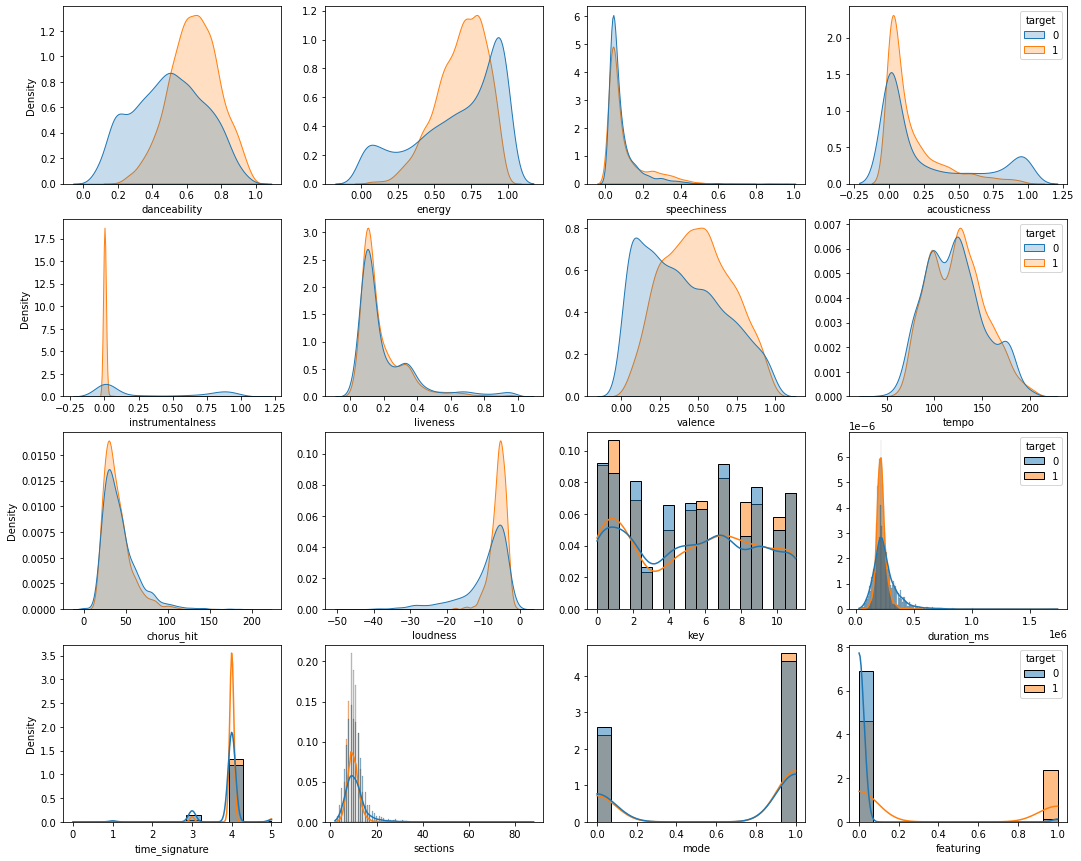

In [5]:
#VISUALIZE DISTRIBUTION DENSITY OF FEATURES PER TARGET
def plot_dataset_distribution(ds):
  fig, axes = plt.subplots(4, 4, figsize=(18, 15))
  num=0
  for column in ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']:
    sns.kdeplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", fill=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  for column in ['tempo', 'chorus_hit', 'loudness']:
    sns.kdeplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", fill=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  for column in discrete_features: 
    sns.histplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", stat="density", kde=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  for column in boolean_features: 
    sns.histplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", stat="density", kde=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  plt.show()

plot_dataset_distribution(whole_dataset_unnormalized)

###*CORRELATION:*

<Figure size 1440x720 with 0 Axes>

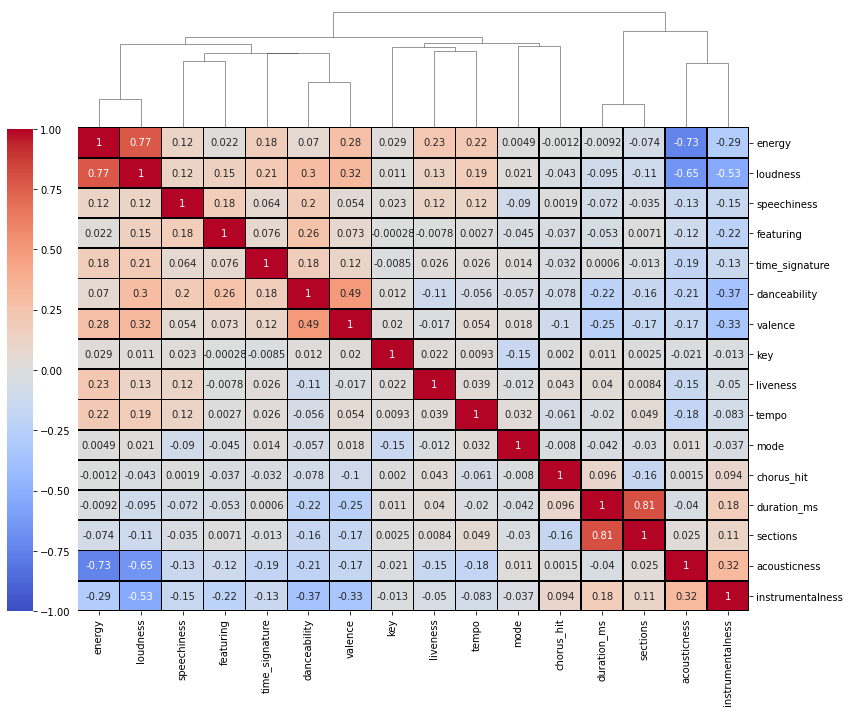


POSITIVE CORRELATION MEAN:  0.11807701987116528  (52.5 %)
NEGATIVE CORRELATION MEAN: -0.1269603112866643 (47.5 %)


In [6]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(20, 10))
#mask = np.zeros_like(correlation_matrix)
#mask[np.triu_indices_from(mask)] = True
#sns.heatmap(correlation_matrix, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=0.5, linecolor='black', mask=mask)
#plt.show()
sns.clustermap(correlation_matrix, center=0, vmin=-1, vmax=1, cmap="coolwarm", linecolor='black', dendrogram_ratio=(.1, .2), cbar_pos=(.02, .145, .03, .67), linewidths=.75, annot=True, fmt='.2g', figsize=(12, 10)).ax_row_dendrogram.remove()
plt.show()

positive_count = 0
negative_count = 0
positive_sum = 0
negative_sum = 0
for i in range(1, len(correlation_matrix)):
  for j in range(i):
    if correlation_matrix.iloc[i, j] > 0:
      positive_count += 1
      positive_sum += correlation_matrix.iloc[i, j]
    else:
      negative_count += 1
      negative_sum += correlation_matrix.iloc[i, j]

print("\nPOSITIVE CORRELATION MEAN:  {}  ({} %)".format(positive_sum / positive_count, (positive_count / (positive_count + negative_count)) * 100))
print("NEGATIVE CORRELATION MEAN: {} ({} %)".format(negative_sum / negative_count, (negative_count / (positive_count + negative_count)) * 100))

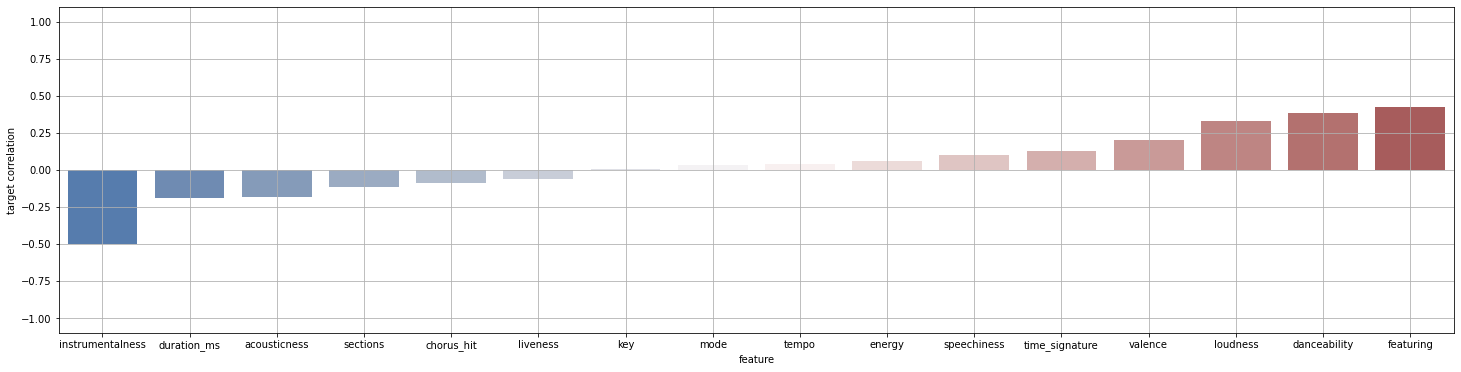


POSITIVE CORRELATION MEAN:  0.17011518360189729  (62.5 %)
NEGATIVE CORRELATION MEAN: -0.18914825072033462 (37.5 %)


In [7]:
plt.figure(figsize=(25, 6))
correlation_target = whole_dataset.corr().loc[primary_features , 'target']
corrDf = pd.DataFrame()
corrDf['col'] = primary_features
corrDf['corr'] = correlation_target.values
corrDf = corrDf.sort_values(by='corr')

sns.barplot(x=corrDf['col'], y=corrDf['corr'], palette="vlag")
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.xlabel('feature')
plt.ylabel('target correlation')
plt.show()

positive_count = 0
negative_count = 0
positive_sum = 0
negative_sum = 0
for num in correlation_target:
  if num > 0:
    positive_count += 1
    positive_sum += num
  else:
    negative_count += 1
    negative_sum += num

print("\nPOSITIVE CORRELATION MEAN:  {}  ({} %)".format(positive_sum / positive_count, (positive_count / len(primary_features)) * 100))
print("NEGATIVE CORRELATION MEAN: {} ({} %)".format(negative_sum / negative_count, (negative_count / len(primary_features)) * 100))

###*BOXPLOTS:*

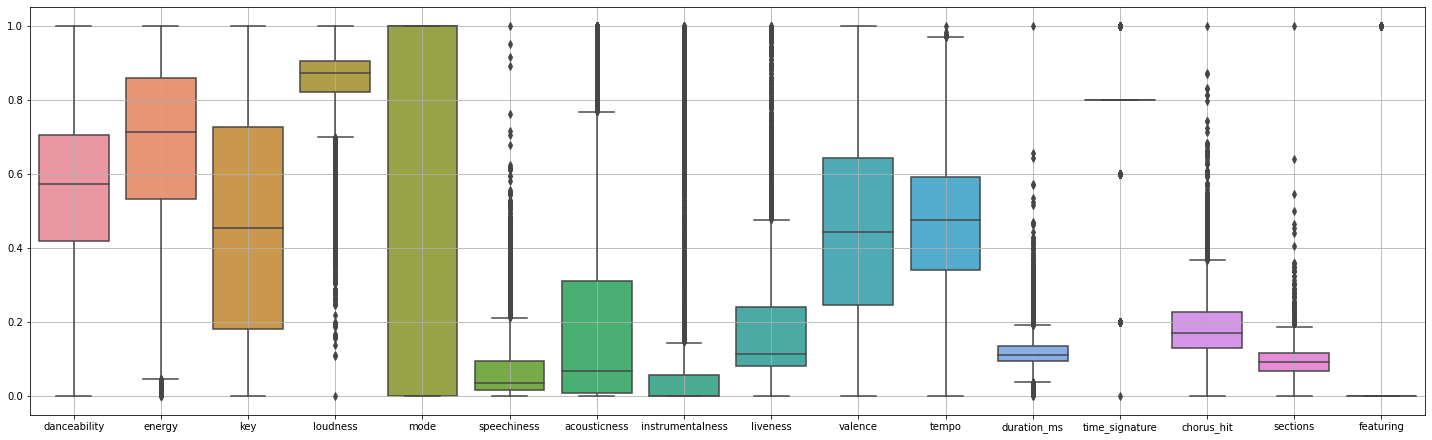

In [8]:
fig = plt.figure(figsize=(25, 7.5))
ax = sns.boxplot(data=dataset)
plt.grid(True)
plt.show()

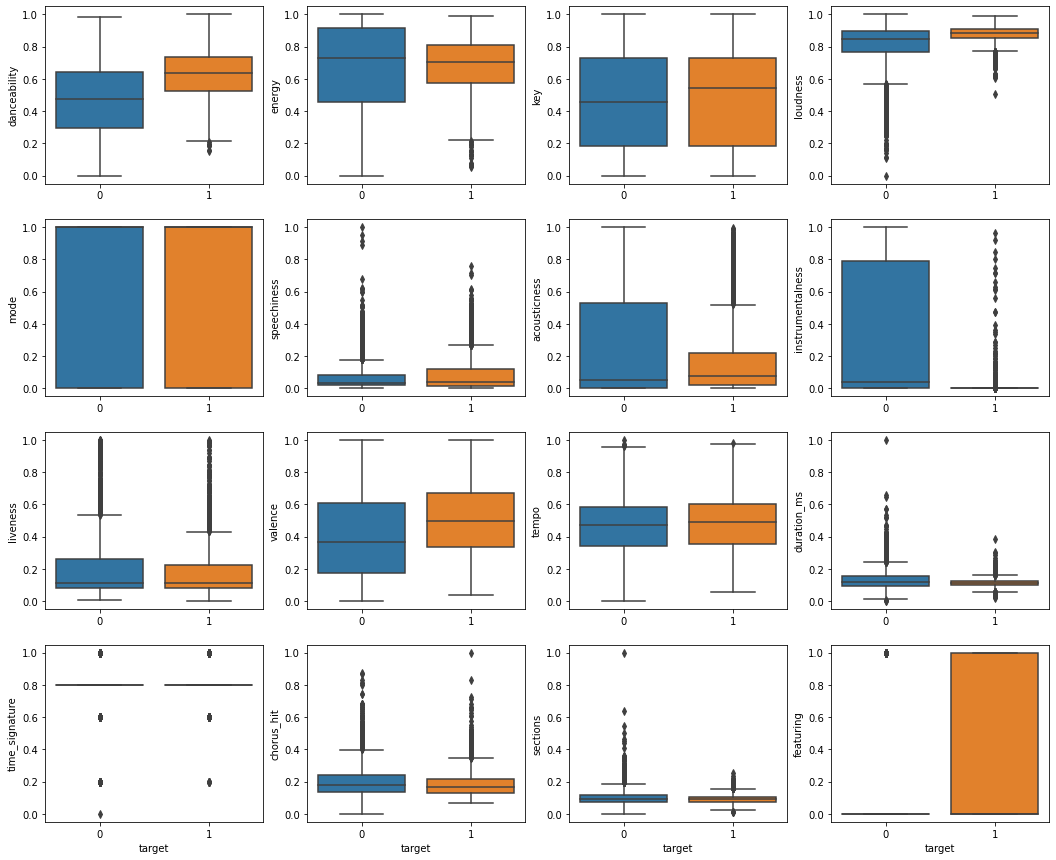

In [9]:
#BOXPLOT PER FEATURE GROUPED BY TARGET
def plot_dataset_boxplots(ds, dsl=True):
  if dsl is True:
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    num=0
    for column in primary_features:
      sns.boxplot(ax=axes[int(num/4), num%4], data=ds, x='target', y=column)
      if num < 12:
        axes[int(num/4), num%4].xaxis.label.set_visible(False)
      num+=1
    plt.show()
  else:
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    tmp = ds.copy()
    tmp['target'] = dsl.values
    num=0
    for column in primary_features:
      sns.boxplot(ax=axes[int(num/4), num%4], data=tmp, x='target', y=column)
      if num < 12:
        axes[int(num/4), num%4].xaxis.label.set_visible(False)
      num+=1
    plt.show()

plot_dataset_boxplots(whole_dataset)

###*PRINCIPAL COMPONENT ANALISYS:*

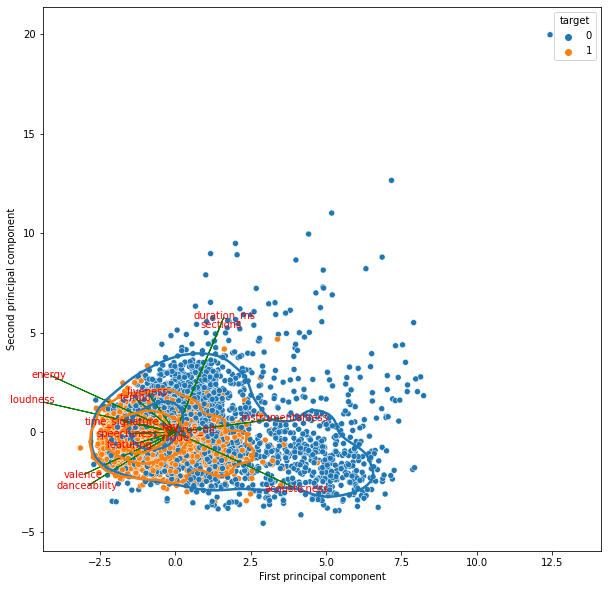

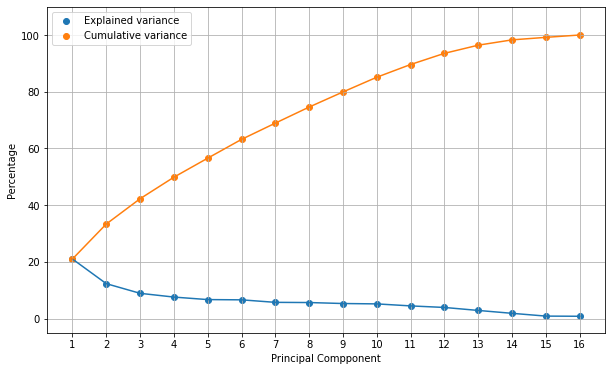

In [10]:
def plot_pca(ds, dsl, plot_variance=True):  
  #CALCULATE PCA
  scaler = StandardScaler()
  scaler.fit(ds[primary_features])
  X=scaler.transform(ds[primary_features])    
  pca = PCA()
  x_pca = pca.fit_transform(X)

  #FILL PCA DATAFRAME
  columns = []
  for i in range(len(primary_features)):
    columns.append("PC{}".format(i+1))
  PCAdf = pd.DataFrame(data = x_pca, columns = columns)
  PCAdf['target'] = dsl.values

  #PRINT FIRST 2 PC
  plt.figure(figsize = (10,10))
  plt.xlabel("First principal component")
  plt.ylabel("Second principal component")
  sns.kdeplot(data=PCAdf, x='PC1', y='PC2', hue="target", levels=4, linewidths=2.5)
  sns.scatterplot(data=PCAdf, x='PC1', y='PC2', hue="target")
  for i in range(len(primary_features)):
    plt.arrow(0, 0, pca.components_.T[i,0] * 10, pca.components_.T[i,1] * 10,color = 'g')
    plt.text(pca.components_.T[i,0]* 10.15, pca.components_.T[i,1] * 10.15, primary_features[i], color = 'r', ha = 'center', va = 'center')
  plt.show()

  #PLOT VARIANCE 
  if plot_variance:
    print()
    plt.figure(figsize=(10, 6))
    variance_ratio = pca.explained_variance_ratio_
    xticks = np.arange(16) + 1
    plt.grid(True)
    plt.xticks(xticks)
    plt.ylim(-5, 110)
    plt.ylabel('Percentage')
    plt.xlabel('Principal Compponent')
    plt.scatter(xticks, variance_ratio * 100, label='Explained variance')
    plt.plot(xticks, variance_ratio * 100)
    plt.scatter(xticks, np.cumsum(variance_ratio) * 100, label='Cumulative variance')
    plt.plot(xticks, np.cumsum(variance_ratio) * 100)
    plt.legend()
    plt.show()

plot_pca(dataset, dataset_labels)

###*IQR OUTLIERS:*

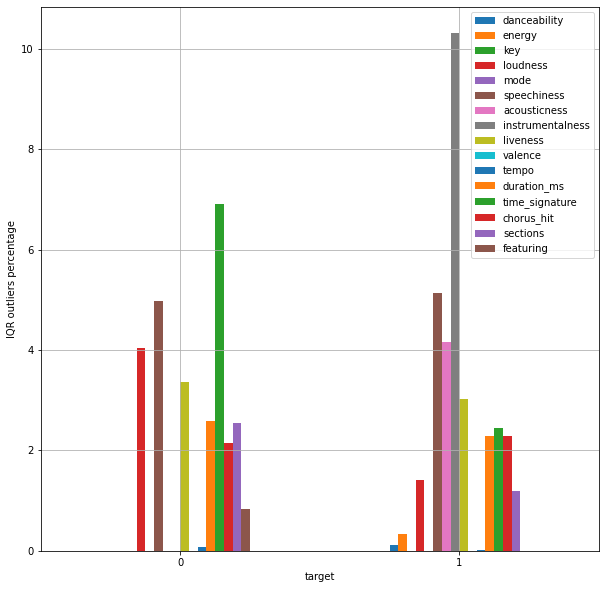


MEAN IQR OUTLIERS PERCENTAGE TARGET 0: 1.717333541731791 %
MEAN IQR OUTLIERS PERCENTAGE TARGET 1: 2.044584245076586 %


In [11]:
clean_dataset = dataset_0.copy()
outliers_dataset_0 = []
for feature in primary_features:
  clean_dataset=clean_dataset.sort_values(by=feature)
  q1, q3= np.percentile(clean_dataset[feature],[25,75])
  iqr=q3-q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr) 
  if lower_bound is not 0 or upper_bound is not 1:
    count_outliers=len(clean_dataset.loc[(clean_dataset[feature] < lower_bound)])
    count_outliers+=len(clean_dataset.loc[(clean_dataset[feature] > upper_bound)])
    outliers_dataset_0.append(count_outliers)
  else:
    outliers_dataset_0.append(0)

clean_dataset = dataset_1.copy()
outliers_dataset_1 = []
for feature in primary_features:
  clean_dataset=clean_dataset.sort_values(by=feature)
  q1, q3= np.percentile(clean_dataset[feature],[25,75])
  iqr=q3-q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr) 
  if lower_bound is not 0 or upper_bound is not 1:
    count_outliers=len(clean_dataset.loc[(clean_dataset[feature] < lower_bound)])
    count_outliers+=len(clean_dataset.loc[(clean_dataset[feature] > upper_bound)])
    outliers_dataset_1.append(count_outliers)
  else:
    outliers_dataset_1.append(0)

def count_IQR_outliers(ds_0, ds_1):
  ds_0 = np.asarray(ds_0) * (100 / len(dataset))
  ds_1 = np.asarray(ds_1) * (100 / len(dataset))
  outliers = pd.DataFrame([ds_0, ds_1], columns=primary_features)
  outliers.plot.bar(xlabel='target', ylabel='IQR outliers percentage', figsize=(10, 10), rot=0)
  plt.grid(True)
  plt.show()

  print('\nMEAN IQR OUTLIERS PERCENTAGE TARGET 0: {} %'.format(ds_0.sum() / len(ds_0)))
  print('MEAN IQR OUTLIERS PERCENTAGE TARGET 1: {} %'.format(ds_1.sum() / len(ds_1)))     

count_IQR_outliers(outliers_dataset_0, outliers_dataset_1) 

In [12]:
cumulative_median_distance = np.zeros(len(dataset))
feature_outlier_percentage = np.zeros(len(dataset))
cumulative_median_distance_separate = np.zeros(len(dataset))
for feature in primary_features:
  q1, q3= np.percentile(dataset_0[feature],[25,75])
  iqr=q3-q1
  lower_bound_0 = q1 - (1.5 * iqr)
  upper_bound_0 = q3 + (1.5 * iqr)
  median_0 = np.median(dataset_0[feature])
  q1, q3= np.percentile(dataset_1[feature],[25,75])
  iqr=q3-q1
  lower_bound_1 = q1 - (1.5 * iqr)
  upper_bound_1 = q3 + (1.5 * iqr)
  median_1 = np.median(dataset_1[feature])
  for idx, value in enumerate(dataset[feature]):
    if dataset_and_labels.loc[idx]['target'] == 0:
      score = np.abs(value - median_0)
      cumulative_median_distance[idx] += score
      score = np.abs(value - median_1)
      cumulative_median_distance_separate[idx] -= 2 * score
      if value < lower_bound_0 or value > upper_bound_0:
        feature_outlier_percentage[idx] += 1
    else:
      score = np.abs(value - median_1)
      cumulative_median_distance[idx] += score
      score = np.abs(value - median_0)
      cumulative_median_distance_separate[idx] -= 2 * score
      if value < lower_bound_1 or value > upper_bound_1:
        feature_outlier_percentage[idx] += 1

dataset_and_labels['cumulative_median_distance'] = cumulative_median_distance
dataset_and_labels['feature_outlier_percentage'] = feature_outlier_percentage * (100 / len(primary_features))
dataset_and_labels['cumulative_median_distance_separate'] = cumulative_median_distance_separate

def drop_by(ds, drop_percentace, by):
  rank_indexes = ds.sort_values(by=by).index
  count_to_delete_0 = count_to_delete_1 = int(len(ds) * (drop_percentace / 200))
  to_delete = []
  for idx in reversed(rank_indexes):
    if ds.loc[idx]['target'] == 0:
      if count_to_delete_0 != 0:
        to_delete.append(idx)
        count_to_delete_0 -= 1
    else:
      if count_to_delete_1 != 0:
        to_delete.append(idx)
        count_to_delete_1 -= 1
    if count_to_delete_0 == 0 and count_to_delete_1 == 0:
      break
  return to_delete

In [13]:
def plot_pca_and_compare_distributions(ds):
  plot_pca(ds[primary_features], dataset_labels.loc[ds.index], False)

  print()

  tmp1 = whole_dataset.copy()
  tmp1['dataset'] = ["vanilla" for x in range(len(tmp1))]
  tmp2 = ds.copy()
  tmp2['dataset'] = ["cleaned" for x in range(len(tmp2))]
  tmp2['target'] = dataset_labels.loc[tmp2.index]
  tmp = pd.concat([tmp1, tmp2])

  fig, axes = plt.subplots(4, 4, figsize=(20, 15))
  num=0
  for column in primary_features:
    sns.violinplot(ax=axes[int(num/4), num%4], x="dataset", y=column, hue="target", data=tmp);
    if num < 12:
      axes[int(num/4), num%4].xaxis.label.set_visible(False)
    if num not in range(3,17,4):
      axes[int(num/4), num%4].legend().remove()
    num+=1
  plt.show()

  print()

  fig, axes = plt.subplots(1, 4, figsize=(25, 5))
  num=0
  for column in ['danceability', 'energy', 'acousticness', 'valence']:
    sns.violinplot(ax=axes[num], x="dataset", y=column, hue="target", data=tmp, split=True);
    if num not in range(3,17,4):
      axes[num].legend().remove()
    num+=1
  plt.show()

  print()

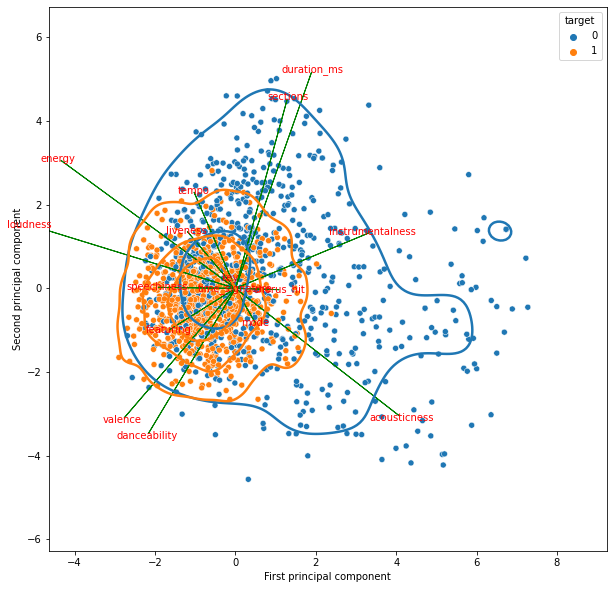

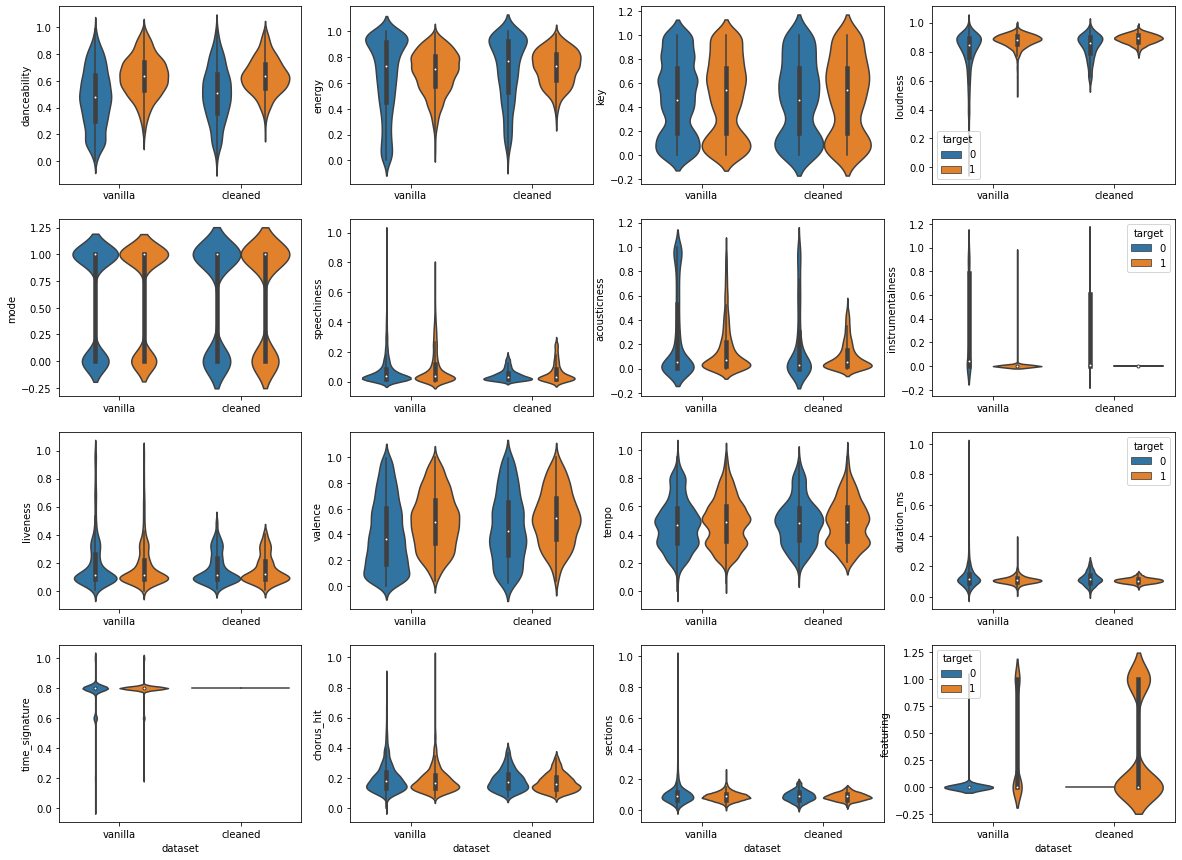

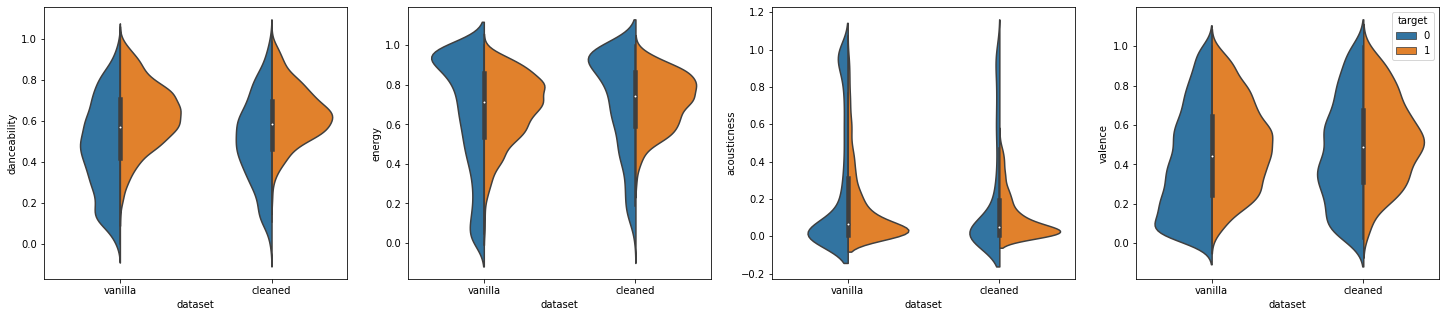

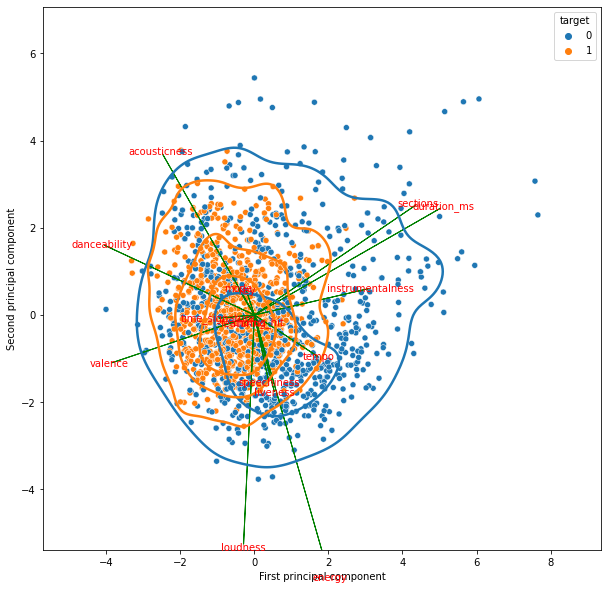

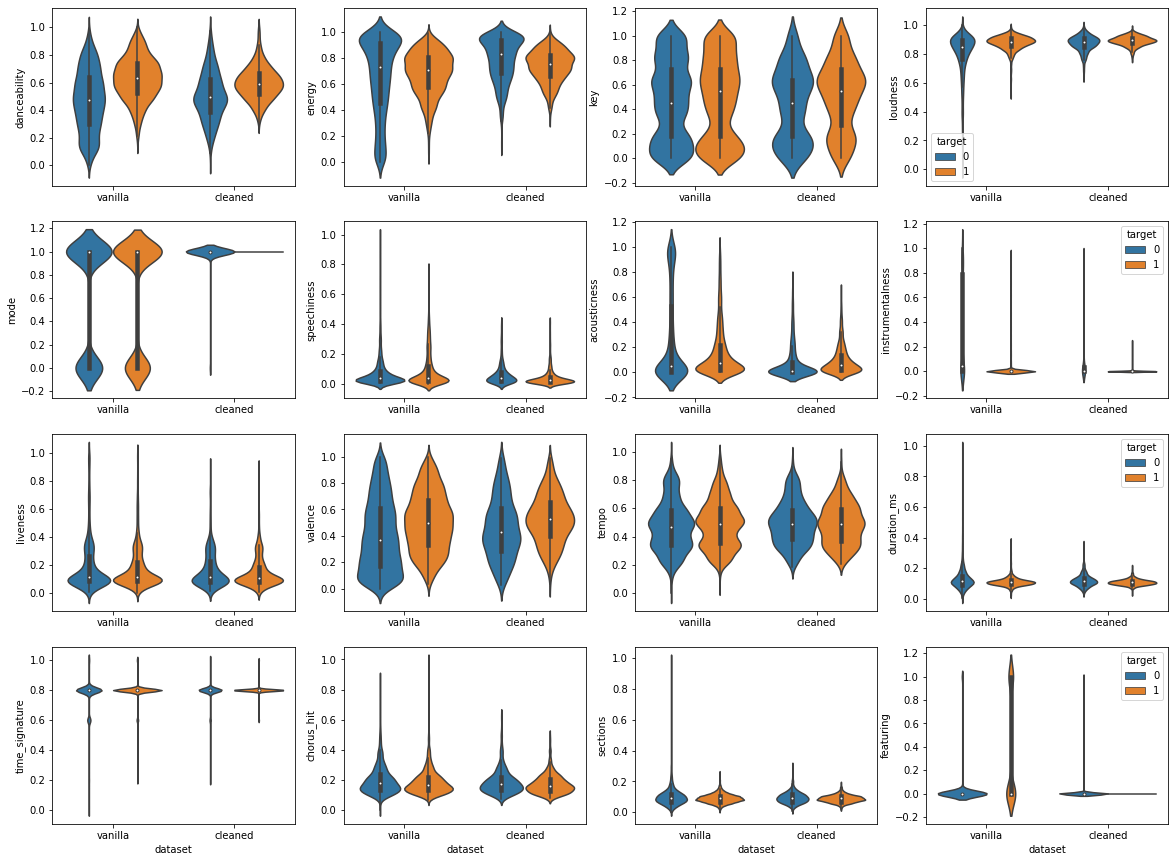

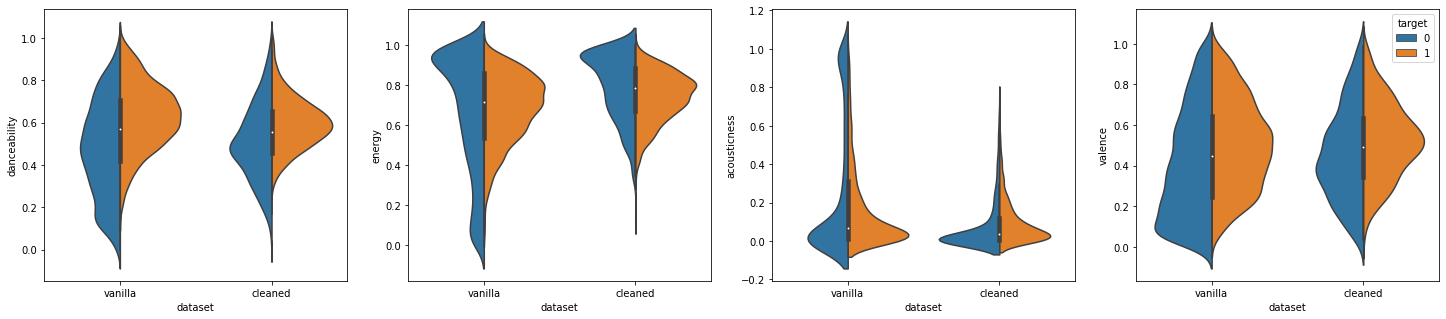

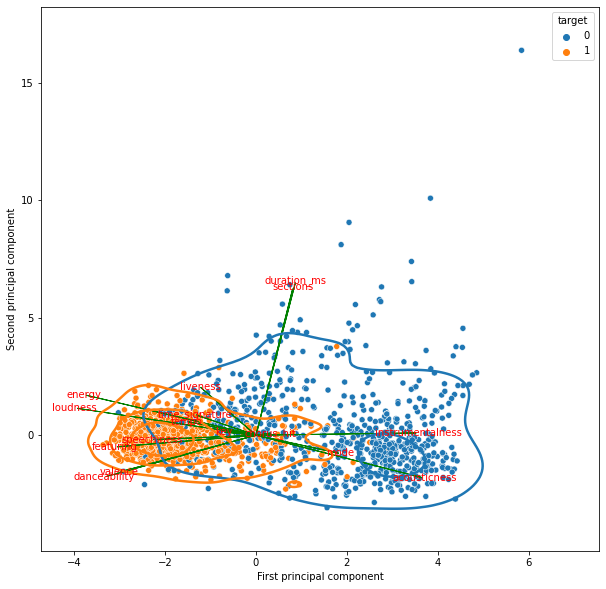

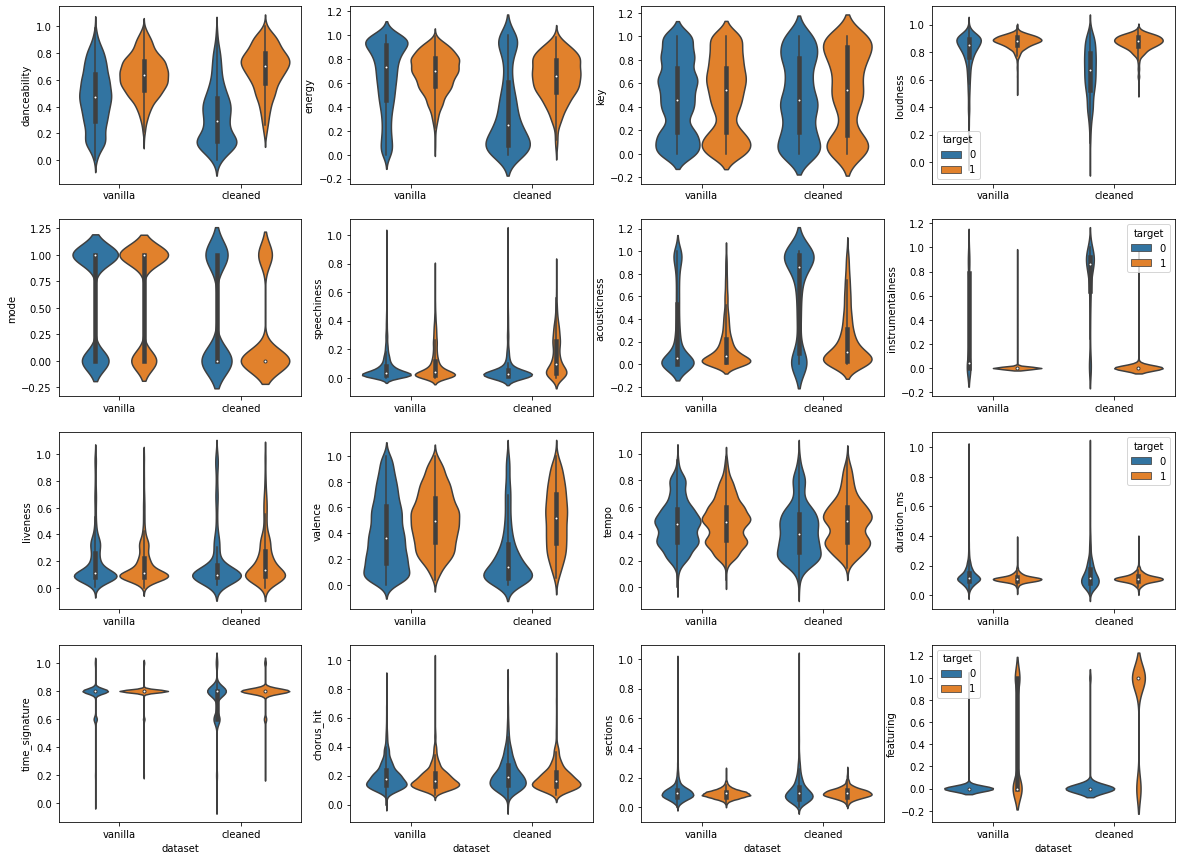

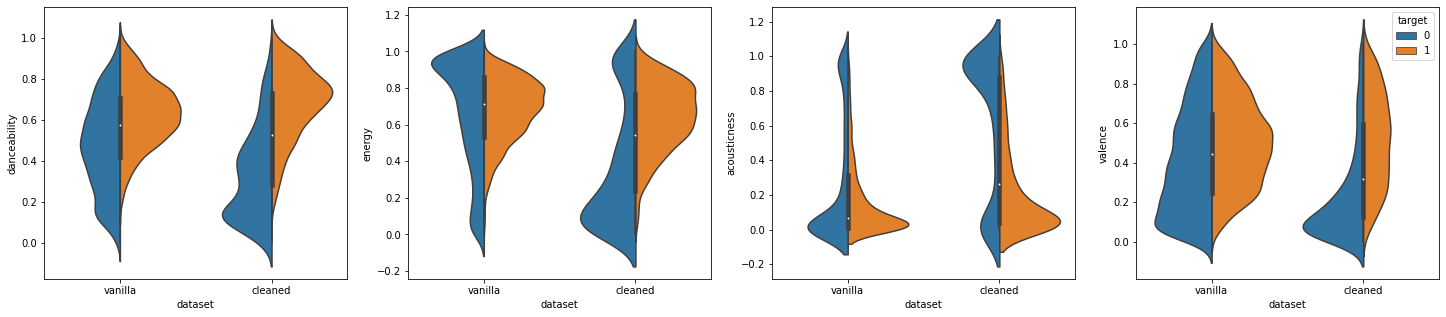

In [14]:
plot_pca_and_compare_distributions(dataset.drop(drop_by(dataset_and_labels, 75, 'feature_outlier_percentage')))
plot_pca_and_compare_distributions(dataset.drop(drop_by(dataset_and_labels, 75, 'cumulative_median_distance')))
plot_pca_and_compare_distributions(dataset.drop(drop_by(dataset_and_labels, 75, 'cumulative_median_distance_separate')))

In [15]:
def custom_cv_splitter(nFolds, ds, drop_strategy, drop_percentage):
  ds = ds.reset_index()
  CViterator = []
  test_dim = int((len(ds) / nFolds) * ((100 - drop_percentage) / 100))
  for fold in range(nFolds):
    train_indices = []
    validation_indices = [] 
    start_test = fold * test_dim
    iter_0 = 0
    iter_1 = 0

    count_0 = count_1 = int(start_test / 2) 
    if start_test % 2 > 0:
      count_0 += 1
    while count_0 > 0 or count_1 > 0:
      if count_0 > 0 and ds.loc[iter_0]['target'] == 0:
        count_0 -= 1
        train_indices.append(iter_0)
        iter_0 += 1
      else:
        if count_0 > 0:
          iter_0 += 1
      if count_1 > 0 and ds.loc[iter_1]['target'] == 1:
        count_1 -= 1
        train_indices.append(iter_1)
        iter_1 += 1
      else:
        if count_1 > 0:
          iter_1 += 1
    
    count_0 = count_1 = int((test_dim)/ 2) 
    if test_dim % 2 > 0:
      count_0 += 1
    while count_0 > 0 or count_1 > 0:
      if iter_0 < len(ds):
        if count_0 > 0 and ds.loc[iter_0]['target'] == 0:
          count_0 -= 1
          validation_indices.append(iter_0)
          iter_0 += 1
        else:
          if count_0 > 0:
            iter_0 += 1
      if iter_1 < len(ds):
        if count_1 > 0 and ds.loc[iter_1]['target'] == 1:
          count_1 -= 1
          validation_indices.append(iter_1)
          iter_1 += 1
        else:
          if count_1 > 0:
            iter_1 += 1
      if (count_0 > 0 and iter_0 == len(ds)) or (count_1 > 0 and iter_1 == len(ds)):
        break
 
    while iter_0 < len(ds) or iter_1 < len(ds):
      if iter_0 < len(ds):
        if ds.loc[iter_0]['target'] == 0:
          train_indices.append(iter_0)
        iter_0 += 1
      if iter_1 < len(ds):
        if ds.loc[iter_1]['target'] == 1:
          train_indices.append(iter_1)
        iter_1 += 1

    to_delete = drop_by(ds.loc[train_indices], drop_percentage, drop_strategy)
    yield (np.array([idx for idx in train_indices if idx not in to_delete]), np.array(validation_indices))

In [16]:
def plot_metrics(model_type, grid_result_model, x, y, drop_strategy=None, drop_percentage=0):
  print('Drop strategy: {}, drop percentage: {}'.format(drop_strategy, drop_percentage))
  print("Best validation: %f using %s" % (grid_result_model.best_score_, grid_result_model.best_params_))
  print("Test score: %f" % metrics.accuracy_score(grid_result_model.best_estimator_.predict(x), y))

  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  metrics.plot_roc_curve(grid_result_model.best_estimator_, x, y, ax=axes[0]) 
  metrics.plot_precision_recall_curve(grid_result_model.best_estimator_, x, y, ax=axes[1])
  sns.heatmap(metrics.confusion_matrix(y, grid_result_model.best_estimator_.predict(x)), ax=axes[2], annot=True, fmt="d", vmin=0, cmap="YlGnBu").set(xlabel='predicted label', ylabel='true label')
  plt.show()
  print()

results = pd.DataFrame(columns=['model', 'param1', 'param2', 'param3', 'drop_strategy', 'drop_percentage', 'accuracy_validation', 'accuracy_test'])
x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.15, stratify=dataset_labels, random_state=15)

###*LOGISTIC REGRESSION:*

In [17]:
def train_validate_test_LogisticRegression(df, x_train, y_train, x_test, y_test):
  x_train.reset_index()
  x_test.reset_index()
  y_train.reset_index()
  y_test.reset_index()

  solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  penalty = ['none', 'l1', 'l2', 'elasticnet']
  c_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,  1, 5, 10, 50]

  grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=200), 
                            param_grid=dict(solver=solvers,penalty=penalty,C=c_values), 
                            n_jobs=-1, 
                            cv=5,
                            scoring='accuracy',
                            error_score=0)
  grid_result = grid_search.fit(x_train, y_train)
  plot_metrics('LogisticRegression', grid_result, x_test, y_test)
  df.loc[len(results)] = ['LogisticRegression', grid_result.best_params_.get('solver'), grid_result.best_params_.get('penalty'), grid_result.best_params_.get('C'), 'none', 0, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]

  for drop_strategy in ['feature_outlier_percentage', 'cumulative_median_distance', 'cumulative_median_distance_separate']:
    for drop_percentage in [15, 25, 40]:

      grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=200), 
                                param_grid=dict(solver=solvers,penalty=penalty,C=c_values), 
                                n_jobs=-1, 
                                cv=custom_cv_splitter(5, dataset_and_labels.loc[x_train.index], drop_strategy, drop_percentage),
                                scoring='accuracy',
                                error_score=0)
      grid_result = grid_search.fit(x_train, y_train)
      plot_metrics('LogisticRegression', grid_result, x_test, y_test, drop_strategy, drop_percentage)
      df.loc[len(results)] = ['LogisticRegression', grid_result.best_params_.get('solver'), grid_result.best_params_.get('penalty'), grid_result.best_params_.get('C'), drop_strategy, drop_percentage, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]
  return df

Drop strategy: None, drop percentage: 0
Best validation: 0.820340 using {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Test score: 0.810417


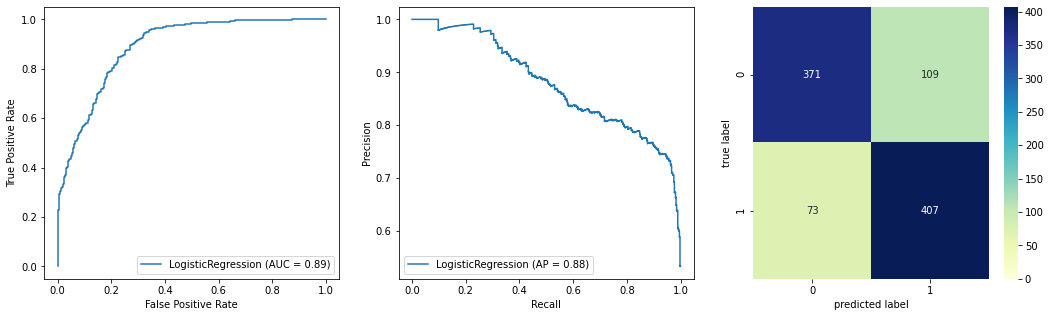


Drop strategy: feature_outlier_percentage, drop percentage: 15
Best validation: 0.811905 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Test score: 0.800000


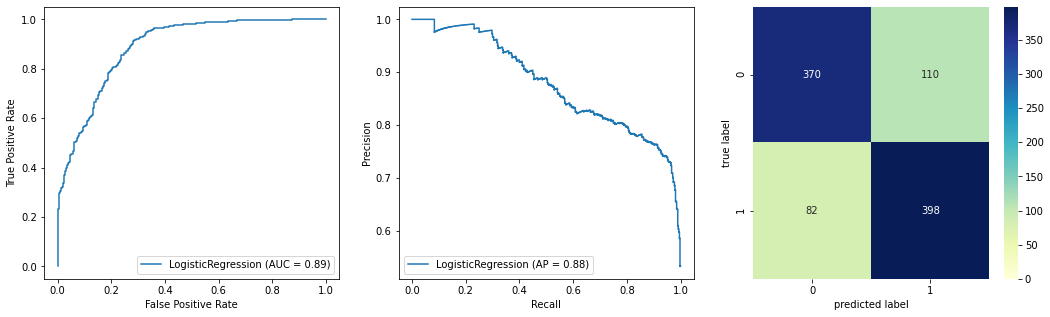


Drop strategy: feature_outlier_percentage, drop percentage: 25
Best validation: 0.811779 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Test score: 0.800000


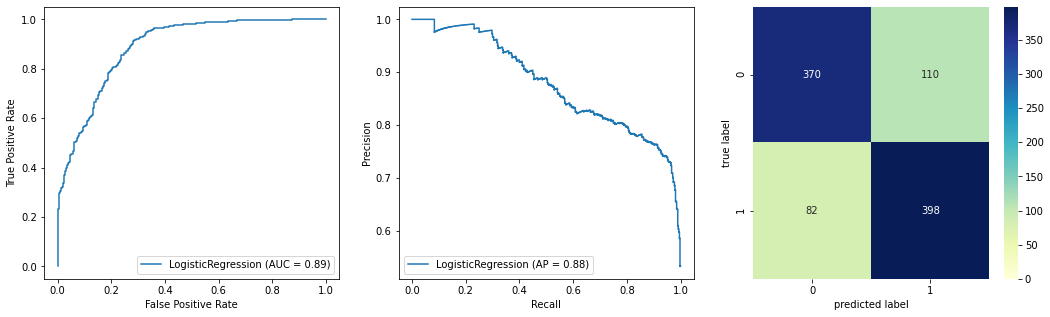


Drop strategy: feature_outlier_percentage, drop percentage: 40
Best validation: 0.812270 using {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Test score: 0.810417


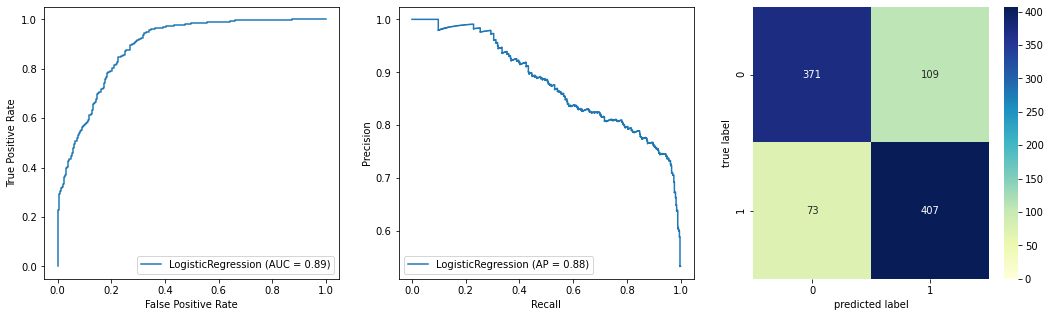


Drop strategy: cumulative_median_distance, drop percentage: 15
Best validation: 0.819697 using {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.803125


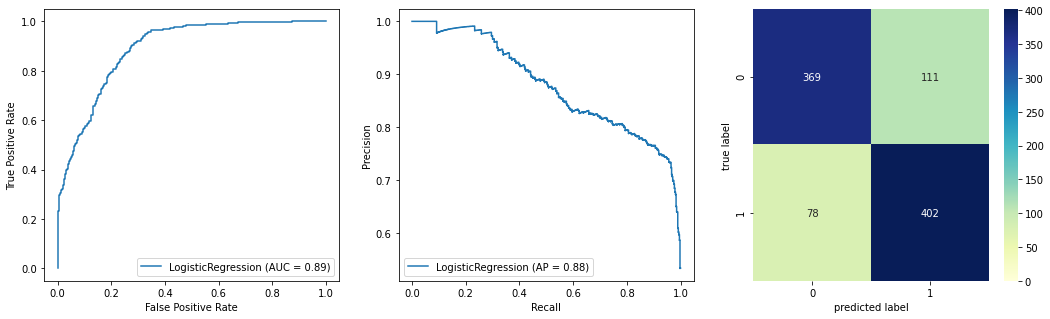


Drop strategy: cumulative_median_distance, drop percentage: 25
Best validation: 0.817669 using {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.801042


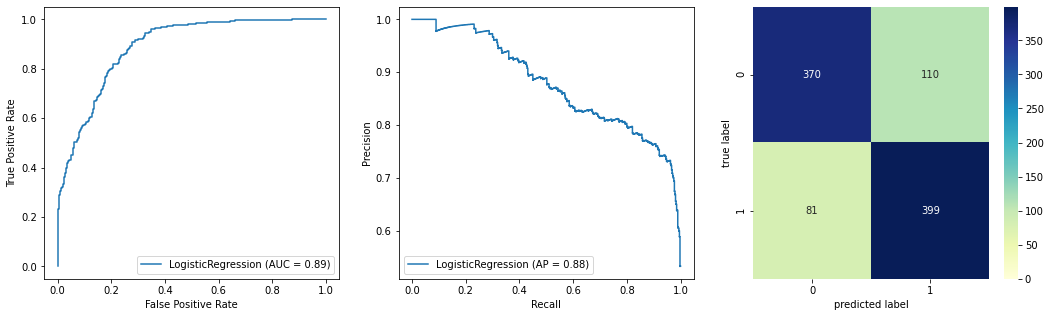


Drop strategy: cumulative_median_distance, drop percentage: 40
Best validation: 0.816258 using {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.806250


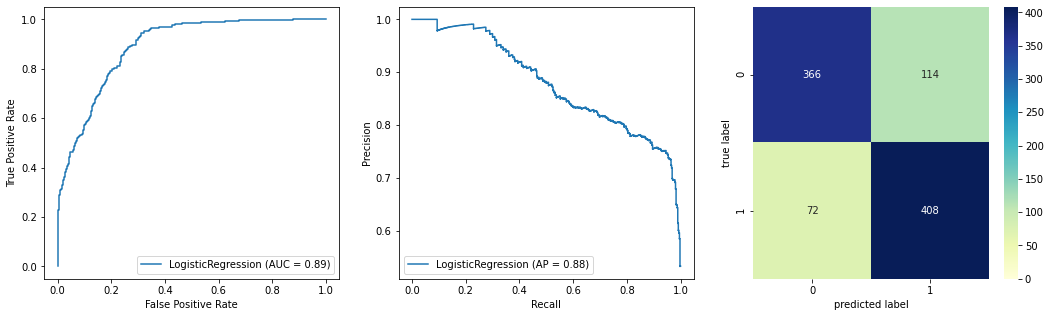


Drop strategy: cumulative_median_distance_separate, drop percentage: 15
Best validation: 0.814502 using {'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}
Test score: 0.803125


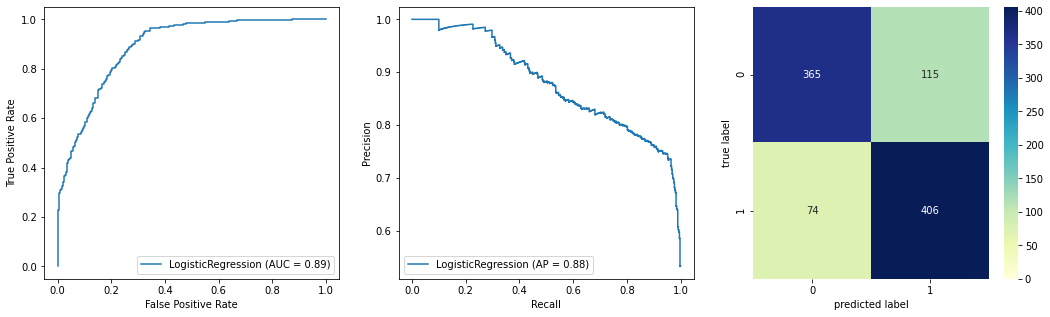


Drop strategy: cumulative_median_distance_separate, drop percentage: 25
Best validation: 0.810061 using {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Test score: 0.802083


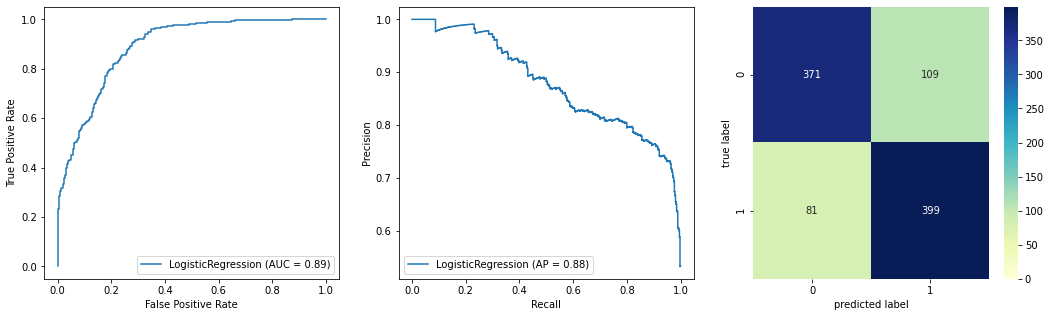


Drop strategy: cumulative_median_distance_separate, drop percentage: 40
Best validation: 0.814110 using {'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}
Test score: 0.803125


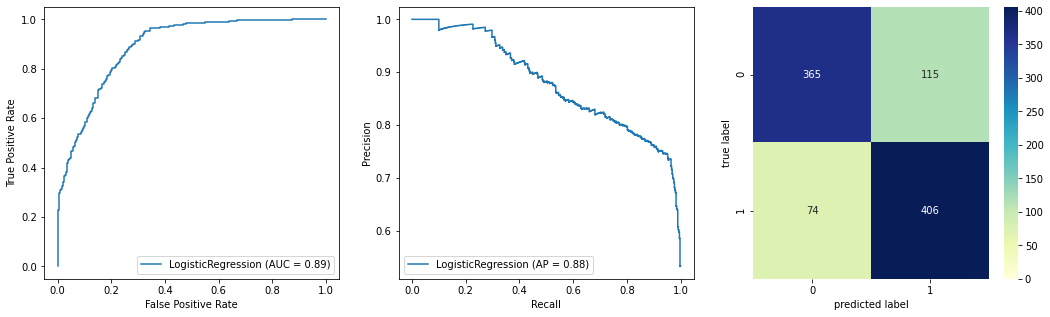

In [18]:
results = train_validate_test_LogisticRegression(results, x_train, y_train, x_test, y_test)

###*KNN:*

In [19]:
def train_validate_test_KNN(df, x_train, y_train, x_test, y_test):
  x_train.reset_index()
  x_test.reset_index()
  y_train.reset_index()
  y_test.reset_index()

  n_neighbors = range(1, 21, 2)
  weights = ['uniform', 'distance']
  metric = ['euclidean', 'manhattan', 'minkowski']

  grid_search = GridSearchCV(estimator=KNeighborsClassifier(), 
                            param_grid=dict(n_neighbors=n_neighbors,weights=weights,metric=metric), 
                            n_jobs=-1, 
                            cv=5,
                            scoring='accuracy',
                            error_score=0)
  grid_result = grid_search.fit(x_train, y_train)
  plot_metrics('KNN', grid_result, x_test, y_test)
  df.loc[len(results)] = ['KNN', grid_result.best_params_.get('n_neighbors'), grid_result.best_params_.get('metric'), grid_result.best_params_.get('weights'), 'none', 0, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]

  for drop_strategy in ['feature_outlier_percentage', 'cumulative_median_distance', 'cumulative_median_distance_separate']:
    for drop_percentage in [15, 25, 40]:

      grid_search = GridSearchCV(estimator=KNeighborsClassifier(), 
                                param_grid=dict(n_neighbors=n_neighbors,weights=weights,metric=metric), 
                                n_jobs=-1, 
                                cv=custom_cv_splitter(5, dataset_and_labels.loc[x_train.index], drop_strategy, drop_percentage),
                                scoring='accuracy',
                                error_score=0)
      grid_result = grid_search.fit(x_train, y_train)
      plot_metrics('KNN', grid_result, x_test, y_test, drop_strategy, drop_percentage)
      df.loc[len(results)] = ['KNN', grid_result.best_params_.get('n_neighbors'), grid_result.best_params_.get('metric'), grid_result.best_params_.get('weights'), drop_strategy, drop_percentage, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]
  return df

Drop strategy: None, drop percentage: 0
Best validation: 0.810595 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Test score: 0.784375


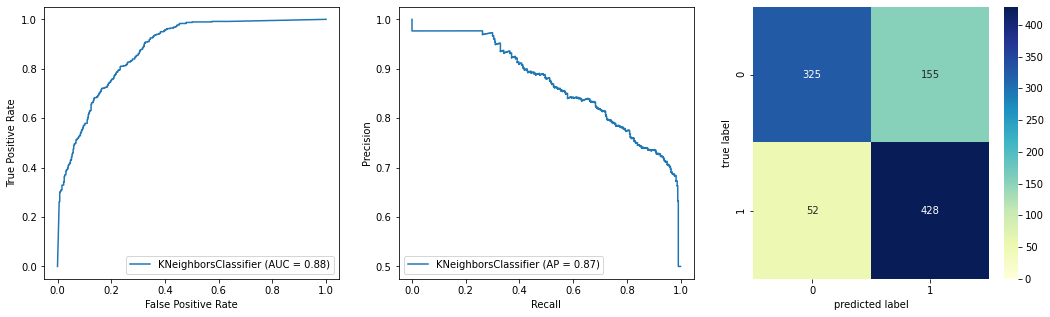


Drop strategy: feature_outlier_percentage, drop percentage: 15
Best validation: 0.810823 using {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Test score: 0.788542


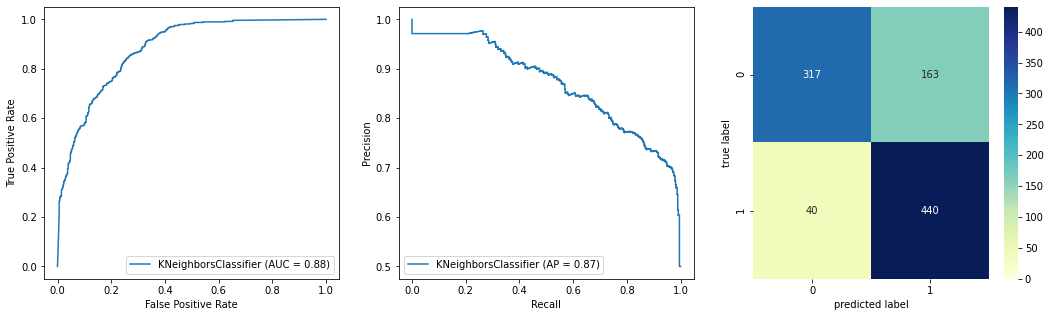


Drop strategy: feature_outlier_percentage, drop percentage: 25
Best validation: 0.813006 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Test score: 0.784375


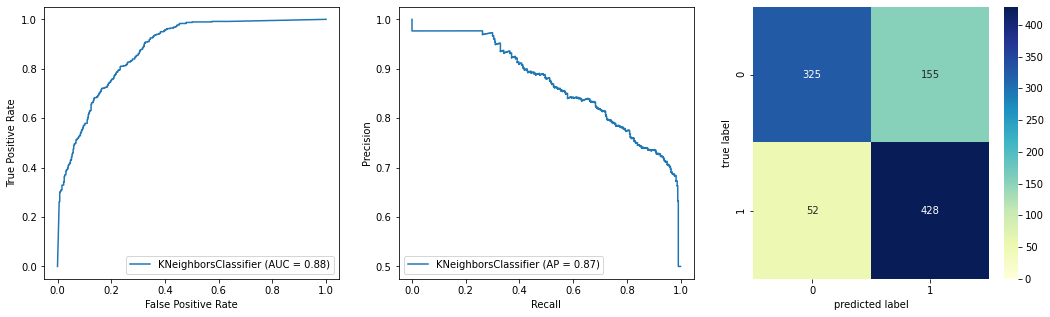


Drop strategy: feature_outlier_percentage, drop percentage: 40
Best validation: 0.805828 using {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Test score: 0.788542


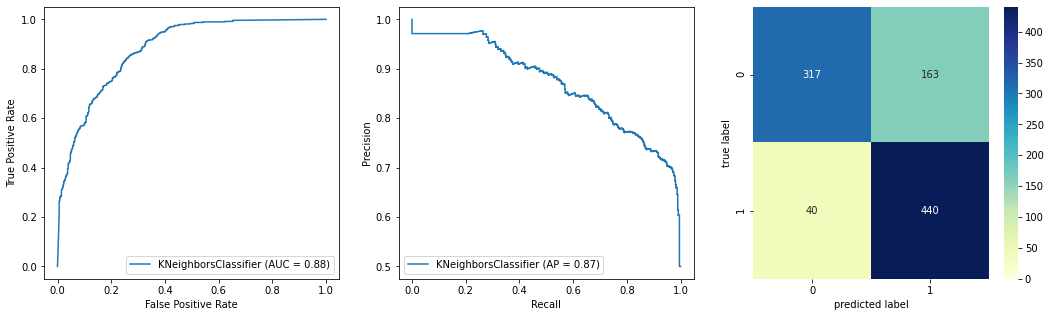


Drop strategy: cumulative_median_distance, drop percentage: 15
Best validation: 0.808658 using {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Test score: 0.788542


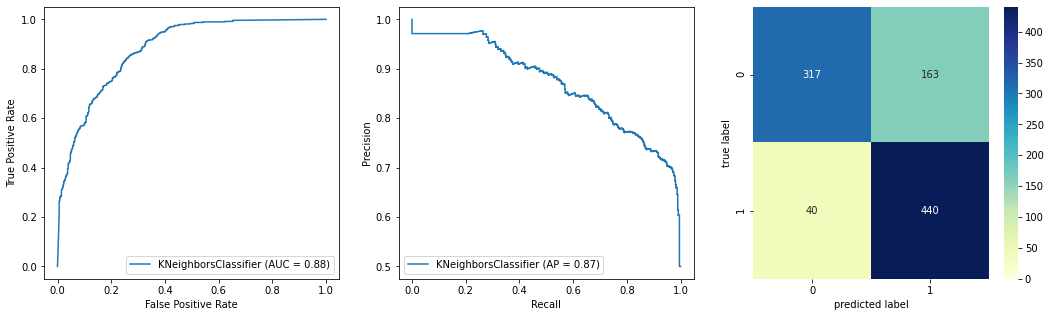


Drop strategy: cumulative_median_distance, drop percentage: 25
Best validation: 0.808098 using {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Test score: 0.788542


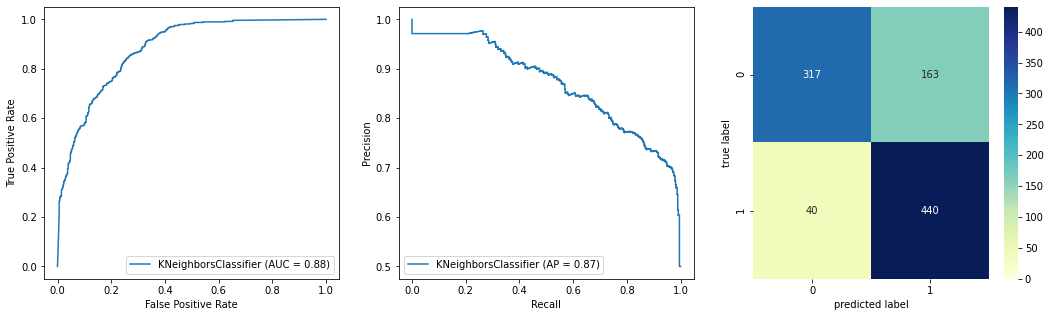


Drop strategy: cumulative_median_distance, drop percentage: 40
Best validation: 0.793252 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Test score: 0.784375


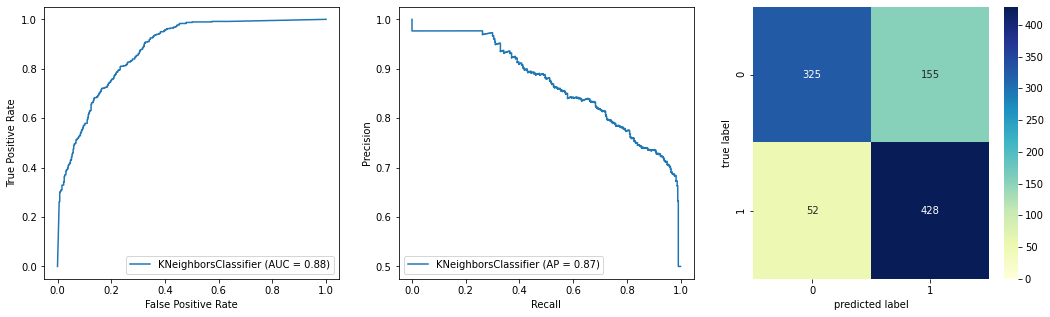


Drop strategy: cumulative_median_distance_separate, drop percentage: 15
Best validation: 0.799567 using {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
Test score: 0.785417


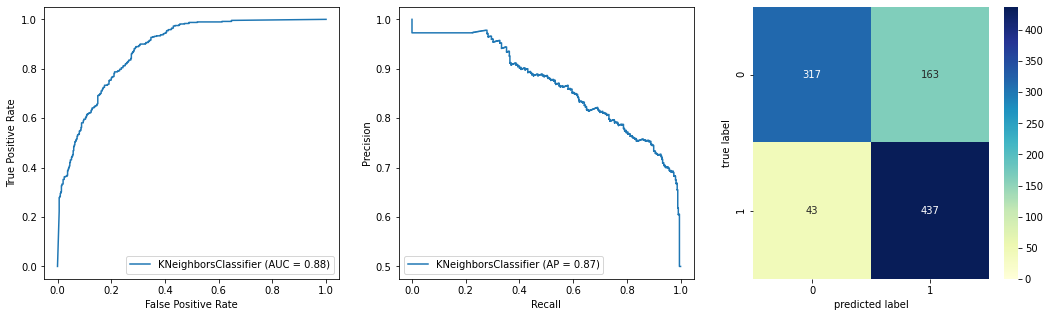


Drop strategy: cumulative_median_distance_separate, drop percentage: 25
Best validation: 0.792883 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Test score: 0.784375


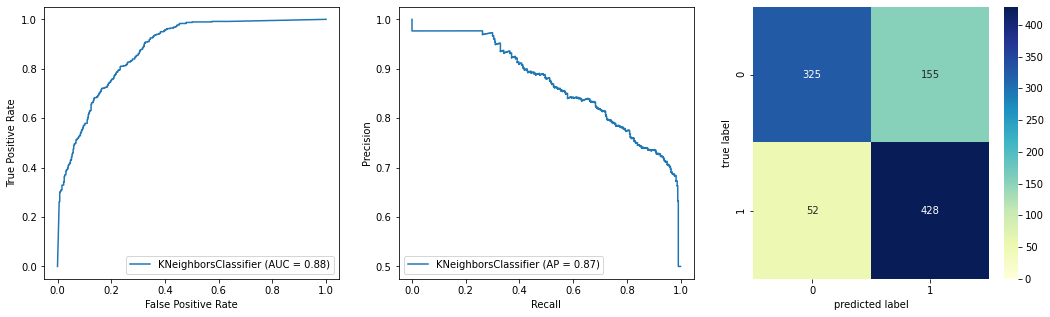


Drop strategy: cumulative_median_distance_separate, drop percentage: 40
Best validation: 0.785890 using {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
Test score: 0.785417


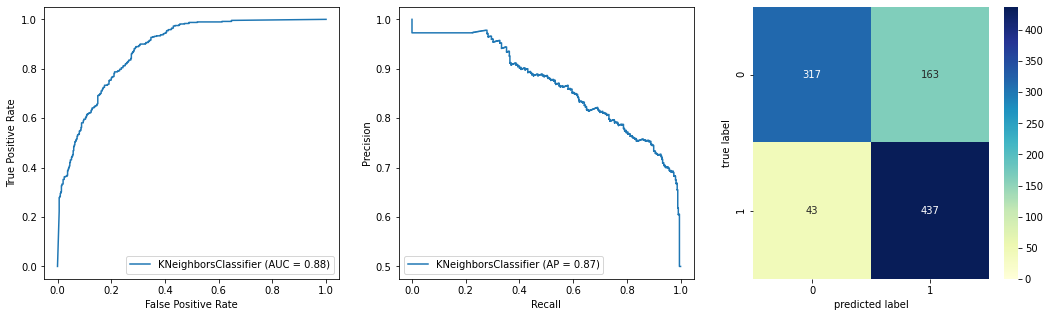

In [20]:
results = train_validate_test_KNN(results, x_train, y_train, x_test, y_test)

###*GAUSSIAN NAIVE BAYES:*

In [21]:
def train_validate_test_GaussianNaiveBayes(df, x_train, y_train, x_test, y_test):
  x_train.reset_index()
  x_test.reset_index()
  y_train.reset_index()
  y_test.reset_index()

  var_smoothing = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

  grid_search = GridSearchCV(estimator=GaussianNB(), 
                            param_grid=dict(var_smoothing=var_smoothing), 
                            n_jobs=-1, 
                            cv=5,
                            scoring='accuracy',
                            error_score=0)
  grid_result = grid_search.fit(x_train, y_train)
  plot_metrics('GaussianNaiveBayes', grid_result, x_test, y_test)
  df.loc[len(results)] = ['GaussianNaiveBayes', grid_result.best_params_.get('var_smoothing'), None, None, 'none', 0, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]

  for drop_strategy in ['feature_outlier_percentage', 'cumulative_median_distance', 'cumulative_median_distance_separate']:
    for drop_percentage in [15, 25, 40]:

      grid_search = GridSearchCV(estimator=GaussianNB(), 
                                param_grid=dict(var_smoothing=var_smoothing), 
                                n_jobs=-1, 
                                cv=custom_cv_splitter(5, dataset_and_labels.loc[x_train.index], drop_strategy, drop_percentage),
                                scoring='accuracy',
                                error_score=0)
      grid_result = grid_search.fit(x_train, y_train)
      plot_metrics('GaussianNaiveBayes', grid_result, x_test, y_test, drop_strategy, drop_percentage)
      df.loc[len(results)] = ['GaussianNaiveBayes', grid_result.best_params_.get('var_smoothing'), None, None, drop_strategy, drop_percentage, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]
  return df

Drop strategy: None, drop percentage: 0
Best validation: 0.778044 using {'var_smoothing': 1e-05}
Test score: 0.753125


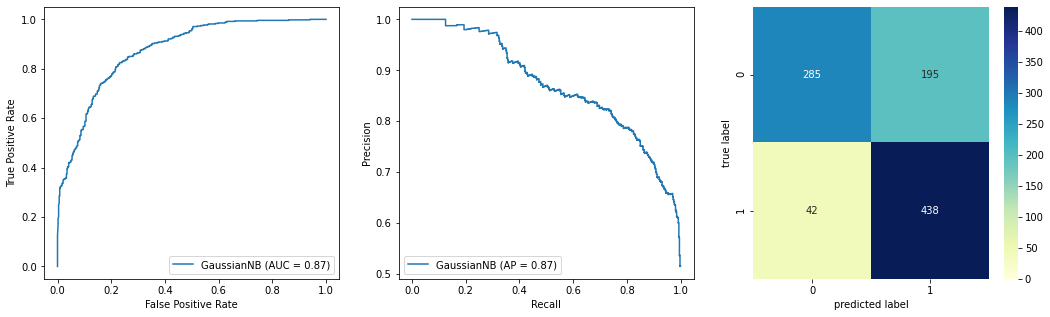


Drop strategy: feature_outlier_percentage, drop percentage: 15
Best validation: 0.787229 using {'var_smoothing': 1e-06}
Test score: 0.753125


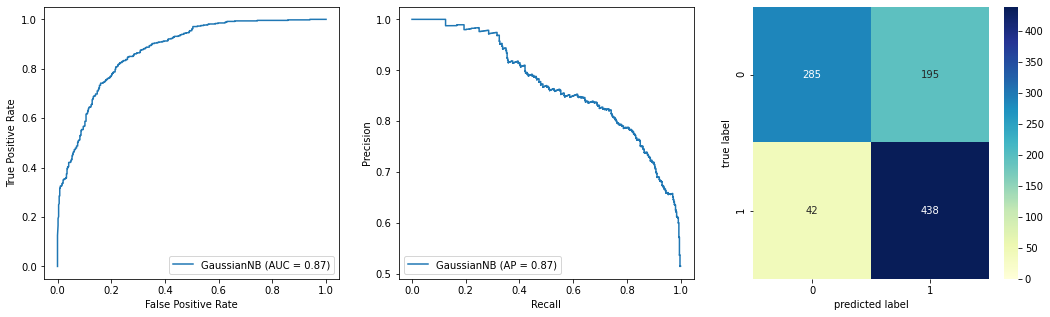


Drop strategy: feature_outlier_percentage, drop percentage: 25
Best validation: 0.785521 using {'var_smoothing': 0.0001}
Test score: 0.752083


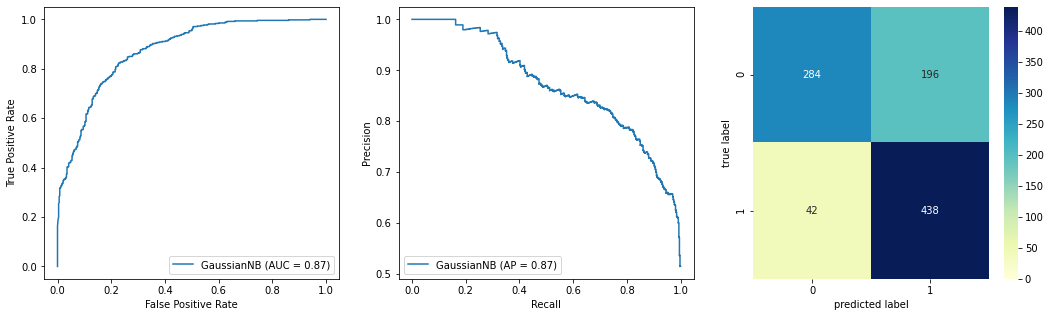


Drop strategy: feature_outlier_percentage, drop percentage: 40
Best validation: 0.783742 using {'var_smoothing': 0.01}
Test score: 0.740625


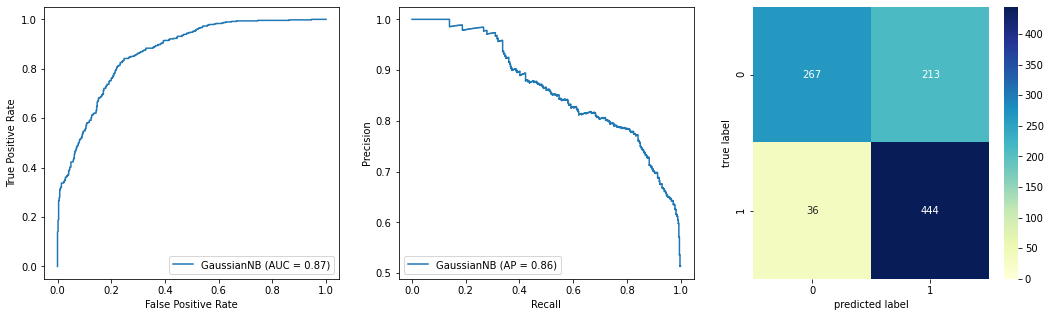


Drop strategy: cumulative_median_distance, drop percentage: 15
Best validation: 0.790909 using {'var_smoothing': 0.0001}
Test score: 0.752083


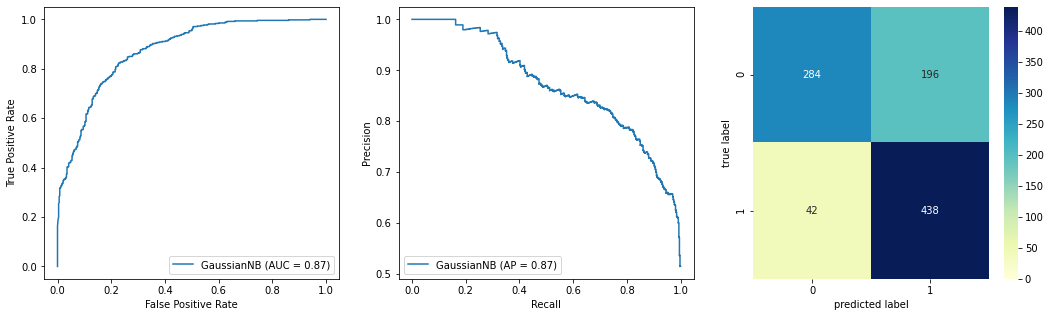


Drop strategy: cumulative_median_distance, drop percentage: 25
Best validation: 0.789693 using {'var_smoothing': 0.0001}
Test score: 0.752083


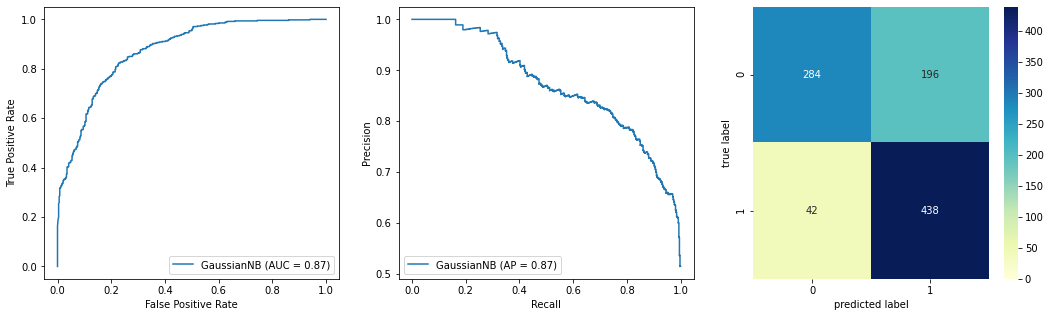


Drop strategy: cumulative_median_distance, drop percentage: 40
Best validation: 0.797853 using {'var_smoothing': 0.0001}
Test score: 0.752083


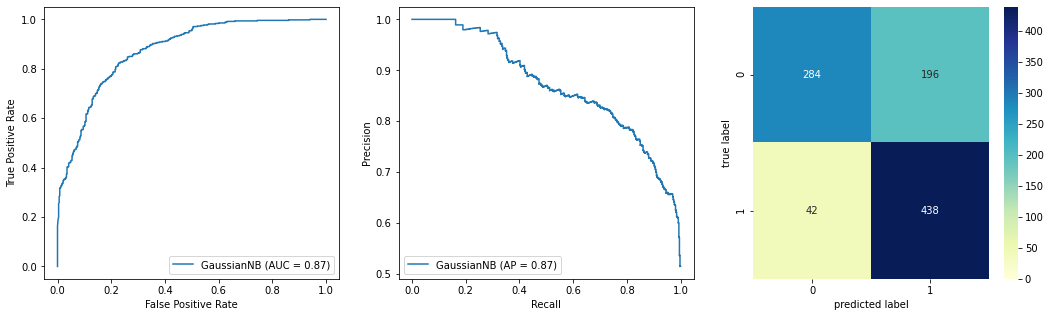


Drop strategy: cumulative_median_distance_separate, drop percentage: 15
Best validation: 0.773377 using {'var_smoothing': 1e-05}
Test score: 0.753125


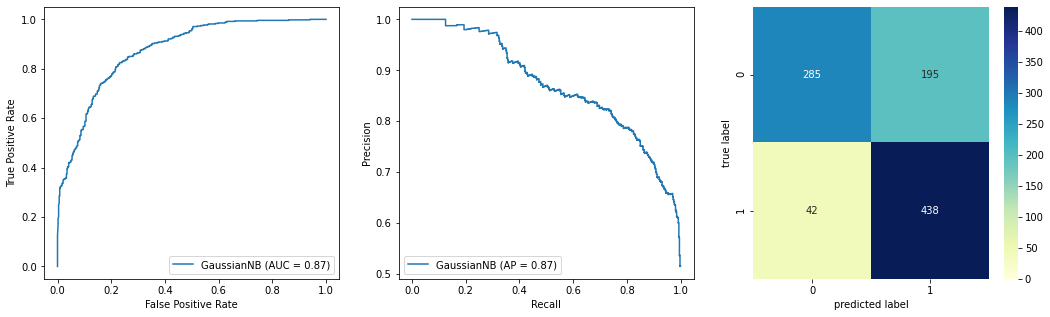


Drop strategy: cumulative_median_distance_separate, drop percentage: 25
Best validation: 0.770061 using {'var_smoothing': 1e-05}
Test score: 0.753125


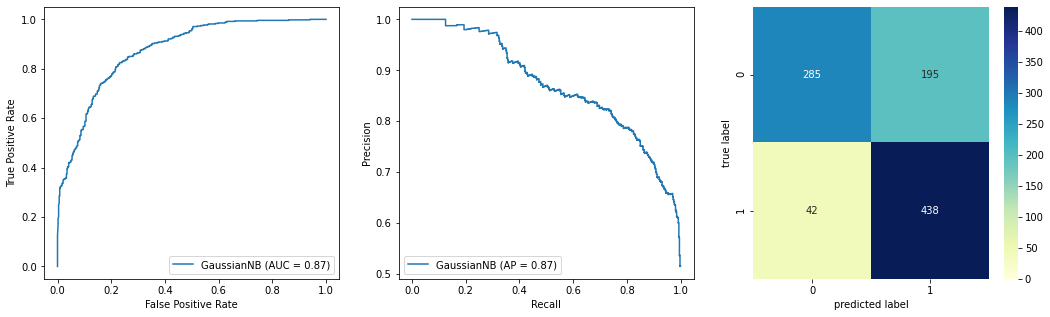


Drop strategy: cumulative_median_distance_separate, drop percentage: 40
Best validation: 0.766564 using {'var_smoothing': 1e-05}
Test score: 0.753125


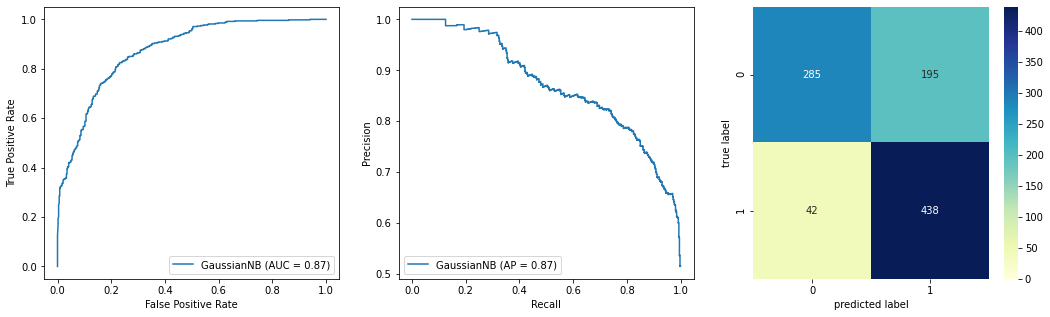

In [22]:
results = train_validate_test_GaussianNaiveBayes(results, x_train, y_train, x_test, y_test)

###*RANDOM FOREST:*

In [23]:
def train_validate_test_RandomForest(df, x_train, y_train, x_test, y_test):
  x_train.reset_index()
  x_test.reset_index()
  y_train.reset_index()
  y_test.reset_index()

  n_estimators = range(250, 1501, 250)
  max_features = ['sqrt', 'log2']

  grid_search = GridSearchCV(estimator=RandomForestClassifier(), 
                            param_grid=dict(n_estimators=n_estimators,max_features=max_features), 
                            n_jobs=-1, 
                            cv=5,
                            scoring='accuracy',
                            error_score=0)
  grid_result = grid_search.fit(x_train, y_train)
  plot_metrics('RandomForest', grid_result, x_test, y_test)
  df.loc[len(results)] = ['RandomForest', grid_result.best_params_.get('n_estimators'), grid_result.best_params_.get('max_features'), None, 'none', 0, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]

  for drop_strategy in ['feature_outlier_percentage', 'cumulative_median_distance', 'cumulative_median_distance_separate']:
    for drop_percentage in [15, 25, 40]:

      grid = dict(n_estimators=n_estimators,max_features=max_features)
      grid_search = GridSearchCV(estimator=RandomForestClassifier(), 
                                param_grid=dict(n_estimators=n_estimators,max_features=max_features), 
                                n_jobs=-1, 
                                cv=custom_cv_splitter(5, dataset_and_labels.loc[x_train.index], drop_strategy, drop_percentage),
                                scoring='accuracy',
                                error_score=0)
      grid_result = grid_search.fit(x_train, y_train)
      plot_metrics('RandomForest', grid_result, x_test, y_test, drop_strategy, drop_percentage)
      df.loc[len(results)] = ['RandomForest', grid_result.best_params_.get('n_estimators'), grid_result.best_params_.get('max_features'), None, drop_strategy, drop_percentage, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]
  return df

Drop strategy: None, drop percentage: 0
Best validation: 0.858220 using {'max_features': 'sqrt', 'n_estimators': 500}
Test score: 0.856250


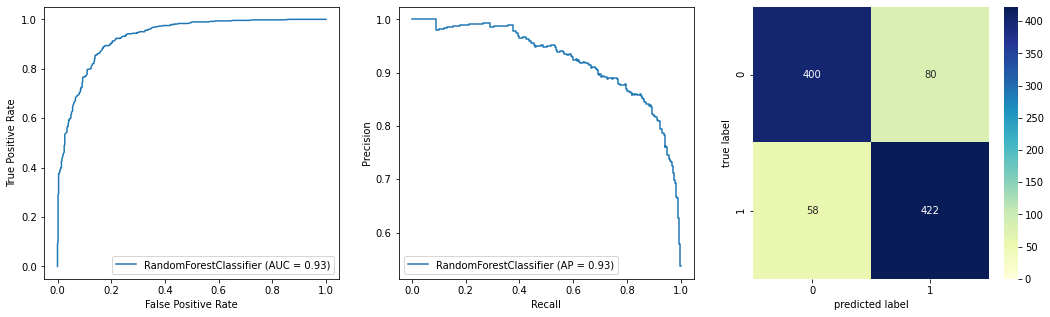


Drop strategy: feature_outlier_percentage, drop percentage: 15
Best validation: 0.849134 using {'max_features': 'sqrt', 'n_estimators': 1000}
Test score: 0.856250


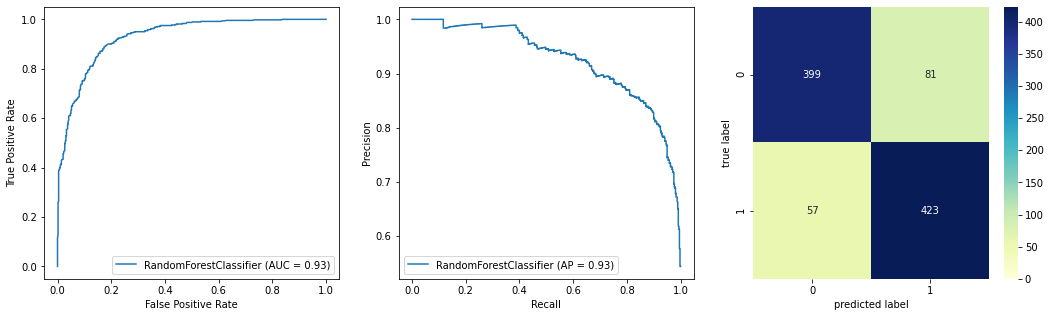


Drop strategy: feature_outlier_percentage, drop percentage: 25
Best validation: 0.841718 using {'max_features': 'sqrt', 'n_estimators': 1250}
Test score: 0.858333


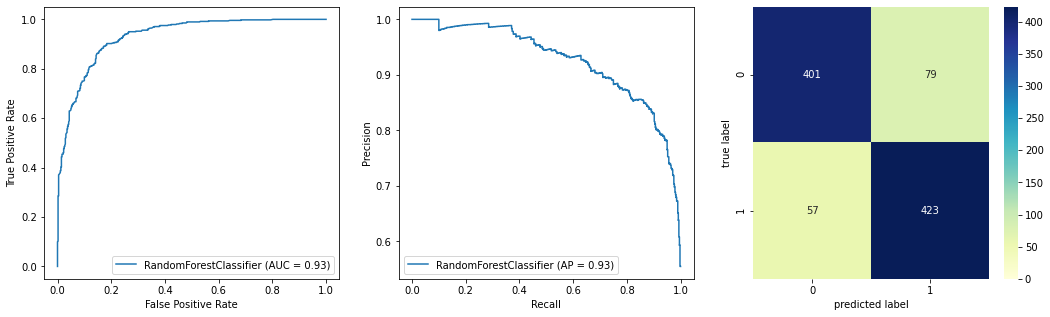


Drop strategy: feature_outlier_percentage, drop percentage: 40
Best validation: 0.830675 using {'max_features': 'sqrt', 'n_estimators': 1500}
Test score: 0.854167


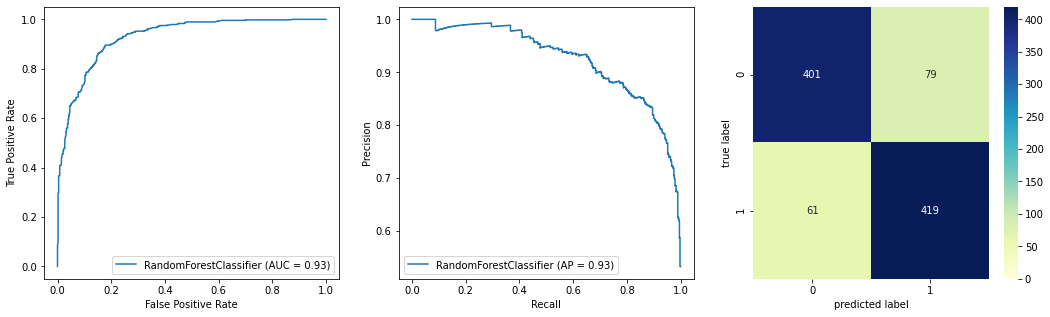


Drop strategy: cumulative_median_distance, drop percentage: 15
Best validation: 0.855195 using {'max_features': 'log2', 'n_estimators': 250}
Test score: 0.860417


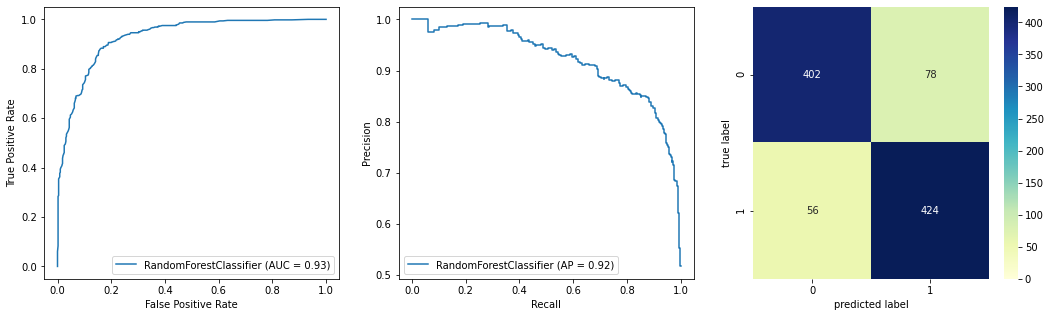


Drop strategy: cumulative_median_distance, drop percentage: 25
Best validation: 0.850061 using {'max_features': 'sqrt', 'n_estimators': 1250}
Test score: 0.851042


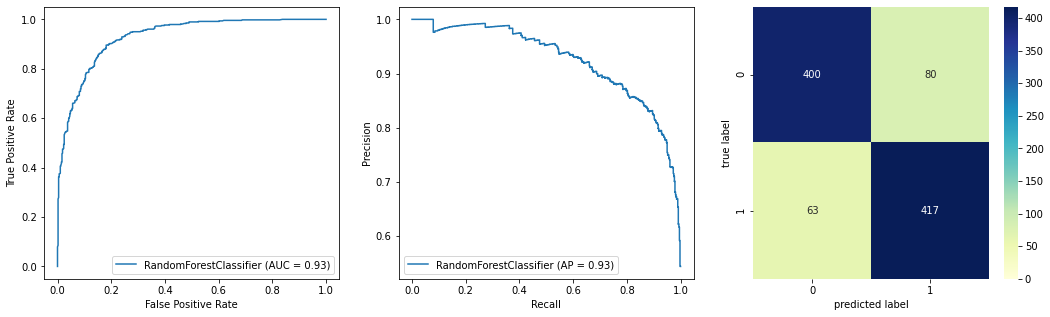


Drop strategy: cumulative_median_distance, drop percentage: 40
Best validation: 0.842025 using {'max_features': 'sqrt', 'n_estimators': 1250}
Test score: 0.855208


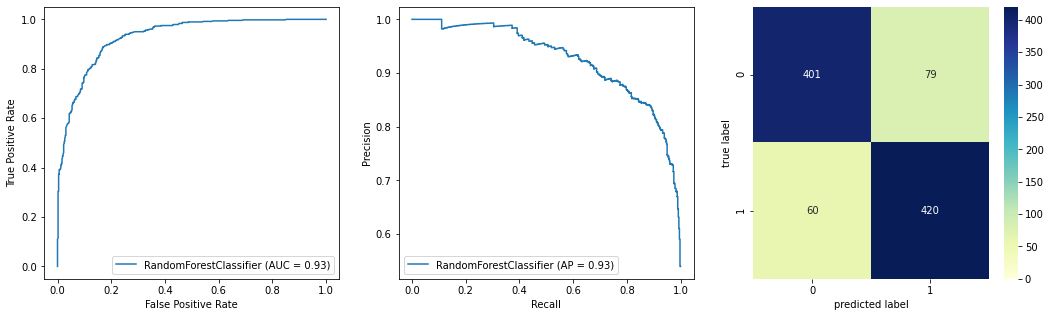

KeyboardInterrupt: ignored

In [24]:
results = train_validate_test_RandomForest(results, x_train, y_train, x_test, y_test)

###*SUPPORT VECTOR MACHINE:*

In [ ]:
def train_validate_test_SVC(df, x_train, y_train, x_test, y_test):
  x_train.reset_index()
  x_test.reset_index()
  y_train.reset_index()
  y_test.reset_index()

  kernel = ['poly', 'rbf', 'sigmoid']
  C = range(1, 50, 1)
  gamma = ['scale']

  grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=dict(kernel=kernel,C=C,gamma=gamma), 
                            n_jobs=-1, 
                            cv=5,
                            scoring='accuracy',
                            error_score=0)
  grid_result = grid_search.fit(x_train, y_train)
  plot_metrics('SVC', grid_result, x_test, y_test)
  df.loc[len(results)] = ['SVC', grid_result.best_params_.get('kernel'), grid_result.best_params_.get('gamma'), grid_result.best_params_.get('C'), 'none', 0, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]

  for drop_strategy in ['feature_outlier_percentage', 'cumulative_median_distance', 'cumulative_median_distance_separate']:
    for drop_percentage in [15, 25, 40]:

      grid_search = GridSearchCV(estimator=SVC(), 
                                param_grid=dict(kernel=kernel,C=C,gamma=gamma), 
                                n_jobs=-1, 
                                cv=custom_cv_splitter(5, dataset_and_labels.loc[x_train.index], drop_strategy, drop_percentage),
                                scoring='accuracy',
                                error_score=0)
      grid_result = grid_search.fit(x_train, y_train)
      plot_metrics('SVC', grid_result, x_test, y_test, drop_strategy, drop_percentage)
      df.loc[len(results)] = ['SVC', grid_result.best_params_.get('kernel'), grid_result.best_params_.get('gamma'), grid_result.best_params_.get('C'), drop_strategy, drop_percentage, grid_result.best_score_, metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test)]
  return df

In [ ]:
results = train_validate_test_SVC(results, x_train, y_train, x_test, y_test)

In [ ]:
results.to_csv(results_path, index = False)

CLASSIFICAZIONE

- Logistic regression

- KNN

- Gaussian Naive Bayes

- Random Forest

- Support Vector Machine  (sia soft sia rbf)

- PCA

grid search cross-validation per hyperparametri perogni

20% test 
80% train cross valid

precision 
roc 
auc 

#ANALISI

- curva di apprendimento

- matrice di confusione

- accuracy
 
- recall